In [129]:
import os
import gc

import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from scipy.stats import linregress

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings('ignore')

## Objectives

- [ ] Baselineを作る。
    - 簡単な特徴量エンジニアリングを行う。
- [ ] TimeSeriesSplitを使ったCVを行う。
- [ ] 予測精度の評価を行う。

## Note

- Validation のラベルデータが配られたら、validation.csvと結合して、trainデータを増やす。

## Scores

## Load Data

In [5]:
def read_data():
    files = ['calendar', 'sample_submission', 'sales_train_validation', 'sell_prices']

    if os.path.exists('/kaggle/input/m5-forecasting-accuracy'):
        data_dir_path = '/kaggle/input/m5-forecasting-accuracy'
        dst_data = {}
        for file in files:
            print(f'Reading {file} ....')
            dst_data[file] = pd.read_csv(data_dir_path + file + '.csv')
    else:
        data_dir_path = '../data/reduced/'
        dst_data = {}
        for file in files:
            print(f'Reading {file} ....')
            dst_data[file] = pd.read_pickle(data_dir_path + file + '.pkl')
    return dst_data.values()

In [6]:
calendar, submission, train, sell_prices = read_data()
test = train.sample(10000).copy(deep=True)

Reading calendar ....
Reading sample_submission ....
Reading sales_train_validation ....
Reading sell_prices ....


In [7]:
print('calendar')
print(calendar.shape)
display(calendar.head())

print('submission')
print(submission.shape)
display(submission.head())

print('train')
print(train.shape)
display(train.head())

print('sell_prices')
print(sell_prices.shape)
display(sell_prices.head())

print('test')
print(test.shape)
display(test.head())

calendar
(1969, 14)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


submission
(60980, 29)


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train
(30490, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


sell_prices
(6841121, 4)


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


test
(10000, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
12371,HOBBIES_1_180_TX_1_validation,HOBBIES_1_180,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
17368,FOODS_2_297_TX_2_validation,FOODS_2_297,FOODS_2,FOODS,TX_2,TX,0,0,0,0,...,2,1,1,2,1,0,1,5,0,1
18084,FOODS_3_615_TX_2_validation,FOODS_3_615,FOODS_3,FOODS,TX_2,TX,0,0,1,1,...,1,1,0,0,1,1,0,0,3,0
3141,HOBBIES_1_095_CA_2_validation,HOBBIES_1_095,HOBBIES_1,HOBBIES,CA_2,CA,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
12122,FOODS_3_754_CA_4_validation,FOODS_3_754,FOODS_3,FOODS,CA_4,CA,0,0,0,0,...,0,1,2,0,0,1,0,1,0,0


### Preprocess Data Transform

In [8]:
def reduce_mem_usage(df, verbose=True):
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [9]:
def encode_calendar(df, filename='encoded_calendar', use_cache=True):
    filepath = f'features/{filename}.pkl'
    if use_cache and os.path.exists(filepath):
        return pd.read_pickle(filepath)

    # Drop Columns
    cols_to_drop = ['weekday', 'wday', 'year']
    df.drop(cols_to_drop, axis=1, inplace=True)
    # Parse Date Feature
    dt_col = 'date'
    df[dt_col] = pd.to_datetime(df[dt_col])
    attrs = [
        "quarter",
        "month",
        "week",
        "day",
        "dayofweek",
        "is_year_end",
        "is_year_start",
        "is_quarter_end",
        "is_quarter_start",
        "is_month_end",
        "is_month_start",
    ]
    for attr in attrs:
        dtype = np.int16 if attr == "year" else np.int8
        df[attr] = getattr(df[dt_col].dt, attr).astype(dtype)

    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(np.int8)
    # MEMO: N_Unique of event_name_1 == 31 and event_name_2 == 5.
    event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    df[event_cols] = df[event_cols].fillna('None')
    for c in event_cols:
        le = preprocessing.LabelEncoder()
        df[c] = le.fit_transform(df[c].values).astype('int8')
    df.to_pickle(filepath)
    return df

In [10]:
# MEMO:
# - 数値の値が入っていない Column は、['date', 'd']
calendar = encode_calendar(calendar, use_cache=True)

In [54]:
def melt_data(df, calendar, sell_prices, encode_maps, filename, use_cache=True):
    filepath = f'features/{filename}.pkl'
    if use_cache and os.path.exists(filepath):
        return pd.read_pickle(filepath)
    # MEMO: ラベルは全データ共通なので、train/test/sell_prices の LabelEncode に使える。
    for label, encode_map in encode_maps.items():
        df[label] = df[label].map(encode_map)
        if label in ['item_id', 'store_id']:
            sell_prices[label] = sell_prices[label].map(encode_map)
    # Melt Main Data and Join Optinal Data.
    id_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    df = pd.melt(df, id_vars=id_columns, var_name='d', value_name='sales')
    df = pd.merge(df, calendar, how='left', on='d')
    df = pd.merge(df, sell_prices, how='left', on=['store_id', 'item_id', 'wm_yr_wk'])
    # MEMO: sell_price を直近価格で過去の値を埋める。
    # - 値が入っていない商品はないが、値が入っていない週は存在する。
    # - 欠損値の原因は、欠品なのか、計測漏れなのか理由が定かでないので、安易に保管するのは危険。
    # - 様々な保管方法を試して、後で、Null Importanceで確かめるなどしたほうがよい。
    # - 上記の理由から、今は欠損値のまま扱う。
    # df['sell_price'] = df.groupby('item_id')['sell_price'].bfill()
    # Cache DataFrame.
    df = df.pipe(reduce_mem_usage)
    df.to_pickle(filepath)
    return df

In [55]:
encode_maps = {}
categorical_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
encode_maps = {col: {label: i for i, label in enumerate(sorted(train[col].unique()))}
                       for col in categorical_cols}

train = melt_data(train, calendar, sell_prices, encode_maps, filename='melted_train', use_cache=True)

In [56]:
print(train.shape)
train.head()

(58327370, 30)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,day,dayofweek,is_year_end,is_year_start,is_quarter_end,is_quarter_start,is_month_end,is_month_start,is_weekend,sell_price
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0,2011-01-29,11101,...,29,5,0,0,0,0,0,0,1,NaN
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0,2011-01-29,11101,...,29,5,0,0,0,0,0,0,1,NaN
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0,2011-01-29,11101,...,29,5,0,0,0,0,0,0,1,NaN
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0,2011-01-29,11101,...,29,5,0,0,0,0,0,0,1,NaN
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0,2011-01-29,11101,...,29,5,0,0,0,0,0,0,1,NaN


## Feature Engineering

- shiftするだけの特徴量
- 予測日数shiftした後、rollingした統計情報
- calendarの情報
    - 翌日休日フラグ
        - CalendarShiftFeature
    - 連休日数
        - 翌日休日フラグを前後にshiftすればよさそう。
- 当該月の特徴量
    - 1日の売上
    - 7, 10, 15, 20日時点の累積売上
        - Calendarにデータを作って、groupby したほうがいいだろうなー。
- 過去１ヶ月での、スーパー全体の売上のうちの自分の売上の割合
    - 相対的にみてよく売れる商品ですよ。というのを言える。
        - てことは、個数で見たほうがいいかもしれない。

In [104]:
class BaseFeature():
    def __init__(self, filename, use_cache=True):
        self.filepath = f'features/{filename}.pkl'
        self.use_cache = use_cache
        self.is_exist_cahce = False
        self.df = pd.DataFrame()
        
    def __enter__(self):
        if self.use_cache:
            self.check_exist_cahce()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        if not self.is_exist_cahce:
            self.df.to_pickle(self.filepath)   # save_cache

    def check_exist_cahce(self):
        if os.path.exists(self.filepath):
            self.is_exist_cahce = True
    
    def get_feature(self, df):
        if self.is_exist_cahce:
            self.df = pd.read_pickle(self.filepath)
            return self.df
        else:
            self.df = self.create_feature(df)
            return self.df

    def create_feature(self, df):
        raise NotImplementedError

In [105]:
class AddSalesFeature(BaseFeature):
    def create_feature(self, df):
        DAYS_PRED = 28
        col = 'sales'
        grouped_df = df.groupby(["id"])[col]

        for diff in [0, 1, 2]:
            shift = DAYS_PRED + diff
            df[f"{col}_lag_t{shift}"] = grouped_df.transform(lambda x: x.shift(shift))

        for window in [7, 30, 60, 90, 180]:
            df[f"{col}_rolling_STD_t{window}"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(window).std())

        for window in [7, 30, 60, 90, 180]:
            df[f"{col}rolling_MEAN_t{window}"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(window).mean())

        for window in [7, 30, 60]:
            df[f"{col}rolling_MIN_t{window}"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(window).min())

        for window in [7, 30, 60]:
            df[f"{col}rolling_MAX_t{window}"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(window).max())

        df[f"{col}_rolling_SKEW_t30"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(30).skew())
        df[f"{col}_rolling_KURT_t30"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(30).kurt())
        return df

In [107]:
class AddPriceFeature(BaseFeature):
    def create_feature(self, df):
        DAYS_PRED = 28
        col = 'sell_price'
        grouped_df = df.groupby(["id"])[col]
        
        for diff in [0]:
            shift = DAYS_PRED + diff
            df[f"{col}_lag_t{shift}"] = grouped_df.transform(lambda x: x.shift(shift))
        
        df[f"{col}_rolling_price_MAX_t365"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(365).max())
        df[f"{col}_price_change_t365"] = \
            (df[f"{col}_rolling_price_MAX_t365"] - df["sell_price"]) / (df[f"{col}_rolling_price_MAX_t365"])
        
        df[f"{col}_rolling_price_std_t7"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(7).std())
        df[f"{col}_rolling_price_std_t30"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(30).std())
        return df.drop(["rolling_price_max_t365"], axis=1)

In [111]:
with AddSalesFeature(filename='add_sales_train', use_cache=True) as feat:
    train = feat.get_feature(train).pipe(reduce_mem_usage)
    
with AddPriceFeature(filename='add_price_train', use_cache=True) as feat:
    train = feat.get_feature(train).pipe(reduce_mem_usage)

Mem. usage decreased to 5840.66 Mb (54.5% reduction)
Mem. usage decreased to 6508.16 Mb (0.0% reduction)


In [112]:
print(train.shape)
train.head()

(58327370, 57)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,salesrolling_MAX_t30,salesrolling_MAX_t60,salesrolling_SKEW_t30,salesrolling_KURT_t30,sell_price_shift_price_t1,sell_price_rolling_price_MAX_t365,sell_price__change_t1,sell_price__change_t365,sell_price_rolling_price_std_t7,sell_price_rolling_price_std_t30
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Training Model and Prediction

In [120]:
def plot_cv_indices(cv, X, y, dt_col, lw=10):
    n_splits = cv.get_n_splits()
    _, ax = plt.subplots(figsize=(20, n_splits))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            X[dt_col],
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    MIDDLE = 15
    LARGE = 20
    ax.set_xlabel("Datetime", fontsize=LARGE)
    ax.set_xlim([X[dt_col].min(), X[dt_col].max()])
    ax.set_ylabel("CV iteration", fontsize=LARGE)
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=MIDDLE)
    ax.set_title("{}".format(type(cv).__name__), fontsize=LARGE)
    return ax

In [121]:
class CustomTimeSeriesSplitter:
    def __init__(self, n_splits=5, train_days=80, test_days=20, dt_col="date"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.dt_col = dt_col

    def split(self, X, y=None, groups=None):
        sec = (X[self.dt_col] - X[self.dt_col][0]).dt.total_seconds()
        duration = sec.max() - sec.min()

        train_sec = 3600 * 24 * self.train_days
        test_sec = 3600 * 24 * self.test_days
        total_sec = test_sec + train_sec
        step = (duration - total_sec) / (self.n_splits - 1)

        for idx in range(self.n_splits):
            train_start = idx * step
            train_end = train_start + train_sec
            test_end = train_end + test_sec

            if idx == self.n_splits - 1:
                test_mask = sec >= train_end
            else:
                test_mask = (sec >= train_end) & (sec < test_end)

            train_mask = (sec >= train_start) & (sec < train_end)
            test_mask = (sec >= train_end) & (sec < test_end)

            yield sec[train_mask].index.values, sec[test_mask].index.values

    def get_n_splits(self):
        return self.n_splits

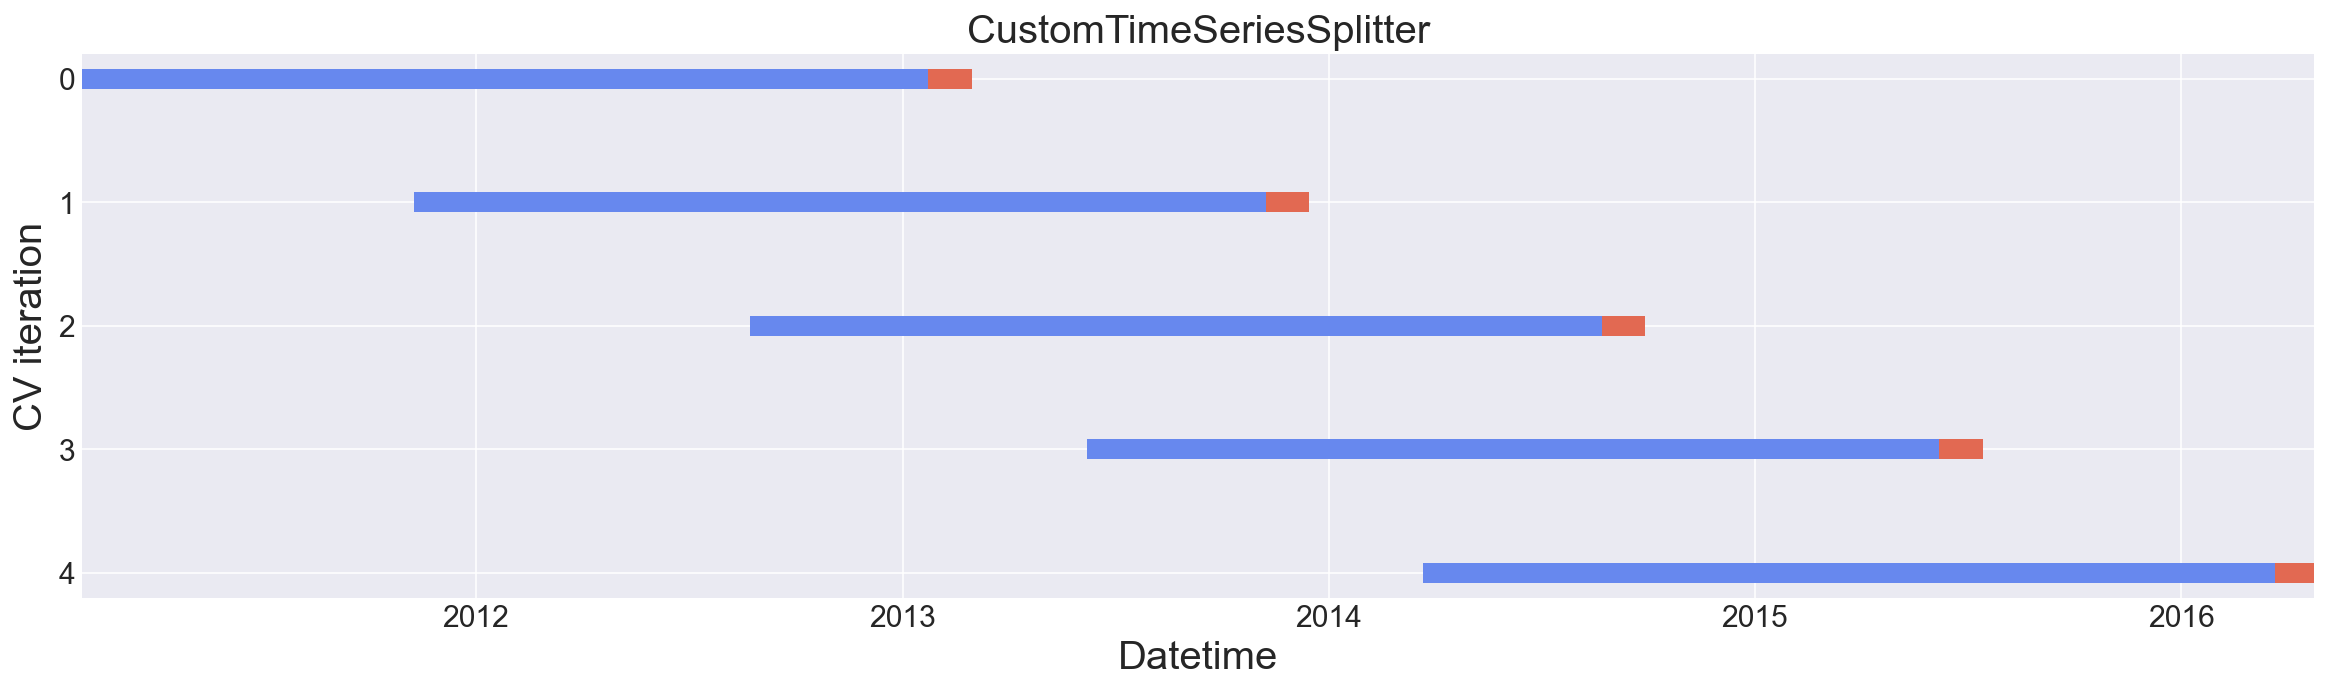

In [124]:
cv_params = {
    "n_splits": 5,
    "train_days": 365 * 2,
    "test_days": 28,
    "dt_col": 'date',
}
cv = CustomTimeSeriesSplitter(**cv_params)
# Plotting all the points takes long time.
plot_cv_indices(cv, train.iloc[::1000][['date']].reset_index(drop=True), None, 'date')

In [133]:
features = train.columns.tolist()
cols_to_drop = ['id', 'wm_yr_wk', 'd', 'sales', 'date']

features = [f for f in features if f not in cols_to_drop]

PRED_INTERVAL = 28
latest_date = train['date'].max()
submit_date = latest_date - datetime.timedelta(days=PRED_INTERVAL)
submit_mask = (train["date"] > submit_date)

eval_date = latest_date - datetime.timedelta(days=PRED_INTERVAL*2)
eval_mask = (train["date"] > eval_date)

X_train, y_train = train[~eval_mask][['date'] + features], train[~eval_mask]['sales']
X_eval, y_eval = train[eval_mask][['date'] + features], train[eval_mask]['sales']
X_submit, y_submit = train[submit_mask][['date'] + features], train[submit_mask]['sales']

In [138]:
def rmsle(preds, data):
    y_true = data.get_label()
    rmsle = np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(preds), 2)))
    return 'RMSLE', rmsle, False

def train_lgb(bst_params, fit_params, X, y, cv, drop_when_train=None):
    models = []

    if drop_when_train is None:
        drop_when_train = []

    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
        print(f"\n---------- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) ----------\n")

        X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        train_set = lgb.Dataset(X_trn.drop(drop_when_train, axis=1), label=y_trn)
        val_set = lgb.Dataset(X_val.drop(drop_when_train, axis=1), label=y_val)

        model = lgb.train(
            bst_params,
            train_set,
            valid_sets=[train_set, val_set],
            valid_names=["train", "valid"],
            **fit_params,
            feval=rmsle,
        )
        models.append(model)

        del idx_trn, idx_val, X_trn, X_val, y_trn, y_val
        gc.collect()

    return models

In [139]:
bst_params = {
    "boosting_type": "gbdt",
    "metric": "None", # "rmse",
    "objective": "poisson",
    "n_jobs": -1,
    "seed": 11,
    "learning_rate": 0.3,
    'max_depth': 5,
    'min_data_in_leaf': 50,
    "bagging_fraction": 0.75,
    "bagging_freq": 10,
    "colsample_bytree": 0.75,
}

fit_params = {
    "num_boost_round": 100_000,
    "early_stopping_rounds": 50,
    "verbose_eval": 100,
}

models = train_lgb(
    bst_params, fit_params, X_train, y_train, cv, drop_when_train=['date']
)

del X_train, y_train
gc.collect()


---------- Fold: (1 / 5) ----------

Training until validation scores don't improve for 50 rounds
[100]	train's RMSLE: 0.436987	valid's RMSLE: 0.489714
[200]	train's RMSLE: 0.433563	valid's RMSLE: 0.489281
[300]	train's RMSLE: 0.431632	valid's RMSLE: 0.4887
Early stopping, best iteration is:
[285]	train's RMSLE: 0.431851	valid's RMSLE: 0.488657

---------- Fold: (2 / 5) ----------

Training until validation scores don't improve for 50 rounds
[100]	train's RMSLE: 0.464044	valid's RMSLE: 0.509964
[200]	train's RMSLE: 0.460847	valid's RMSLE: 0.506123
[300]	train's RMSLE: 0.458913	valid's RMSLE: 0.504716
[400]	train's RMSLE: 0.45738	valid's RMSLE: 0.50393
[500]	train's RMSLE: 0.456282	valid's RMSLE: 0.503064
[600]	train's RMSLE: 0.45518	valid's RMSLE: 0.502619
[700]	train's RMSLE: 0.454504	valid's RMSLE: 0.502025
[800]	train's RMSLE: 0.453856	valid's RMSLE: 0.501884
[900]	train's RMSLE: 0.453219	valid's RMSLE: 0.501659
[1000]	train's RMSLE: 0.452612	valid's RMSLE: 0.501496
[1100]	train's 

0

In [140]:
def get_feature_importance(models):
    feature_importance = pd.DataFrame(
        [model.feature_importance() for model in models],
        columns=models[0].feature_name()
    ).T

    feature_importance['Agerage_Importance'] = feature_importance.iloc[:, :len(models)].mean(axis=1)
    feature_importance['importance_std'] = feature_importance.iloc[:, :len(models)].std(axis=1)
    feature_importance.sort_values(by='Agerage_Importance', inplace=True)
    return feature_importance

def plot_importance(models, max_num_features=50, figsize=(12, 15)):
    feature_importance = get_feature_importance(models)
    plt.figure(figsize=figsize)

    feature_importance[-max_num_features:].plot(
        kind='barh', title='Feature importance', figsize=figsize,
        y='Agerage_Importance', xerr='importance_std',
        grid=True, align="center"
    )
    plt.legend()
    plt.savefig('figure/importance.png')
    plt.show()

<Figure size 864x1080 with 0 Axes>

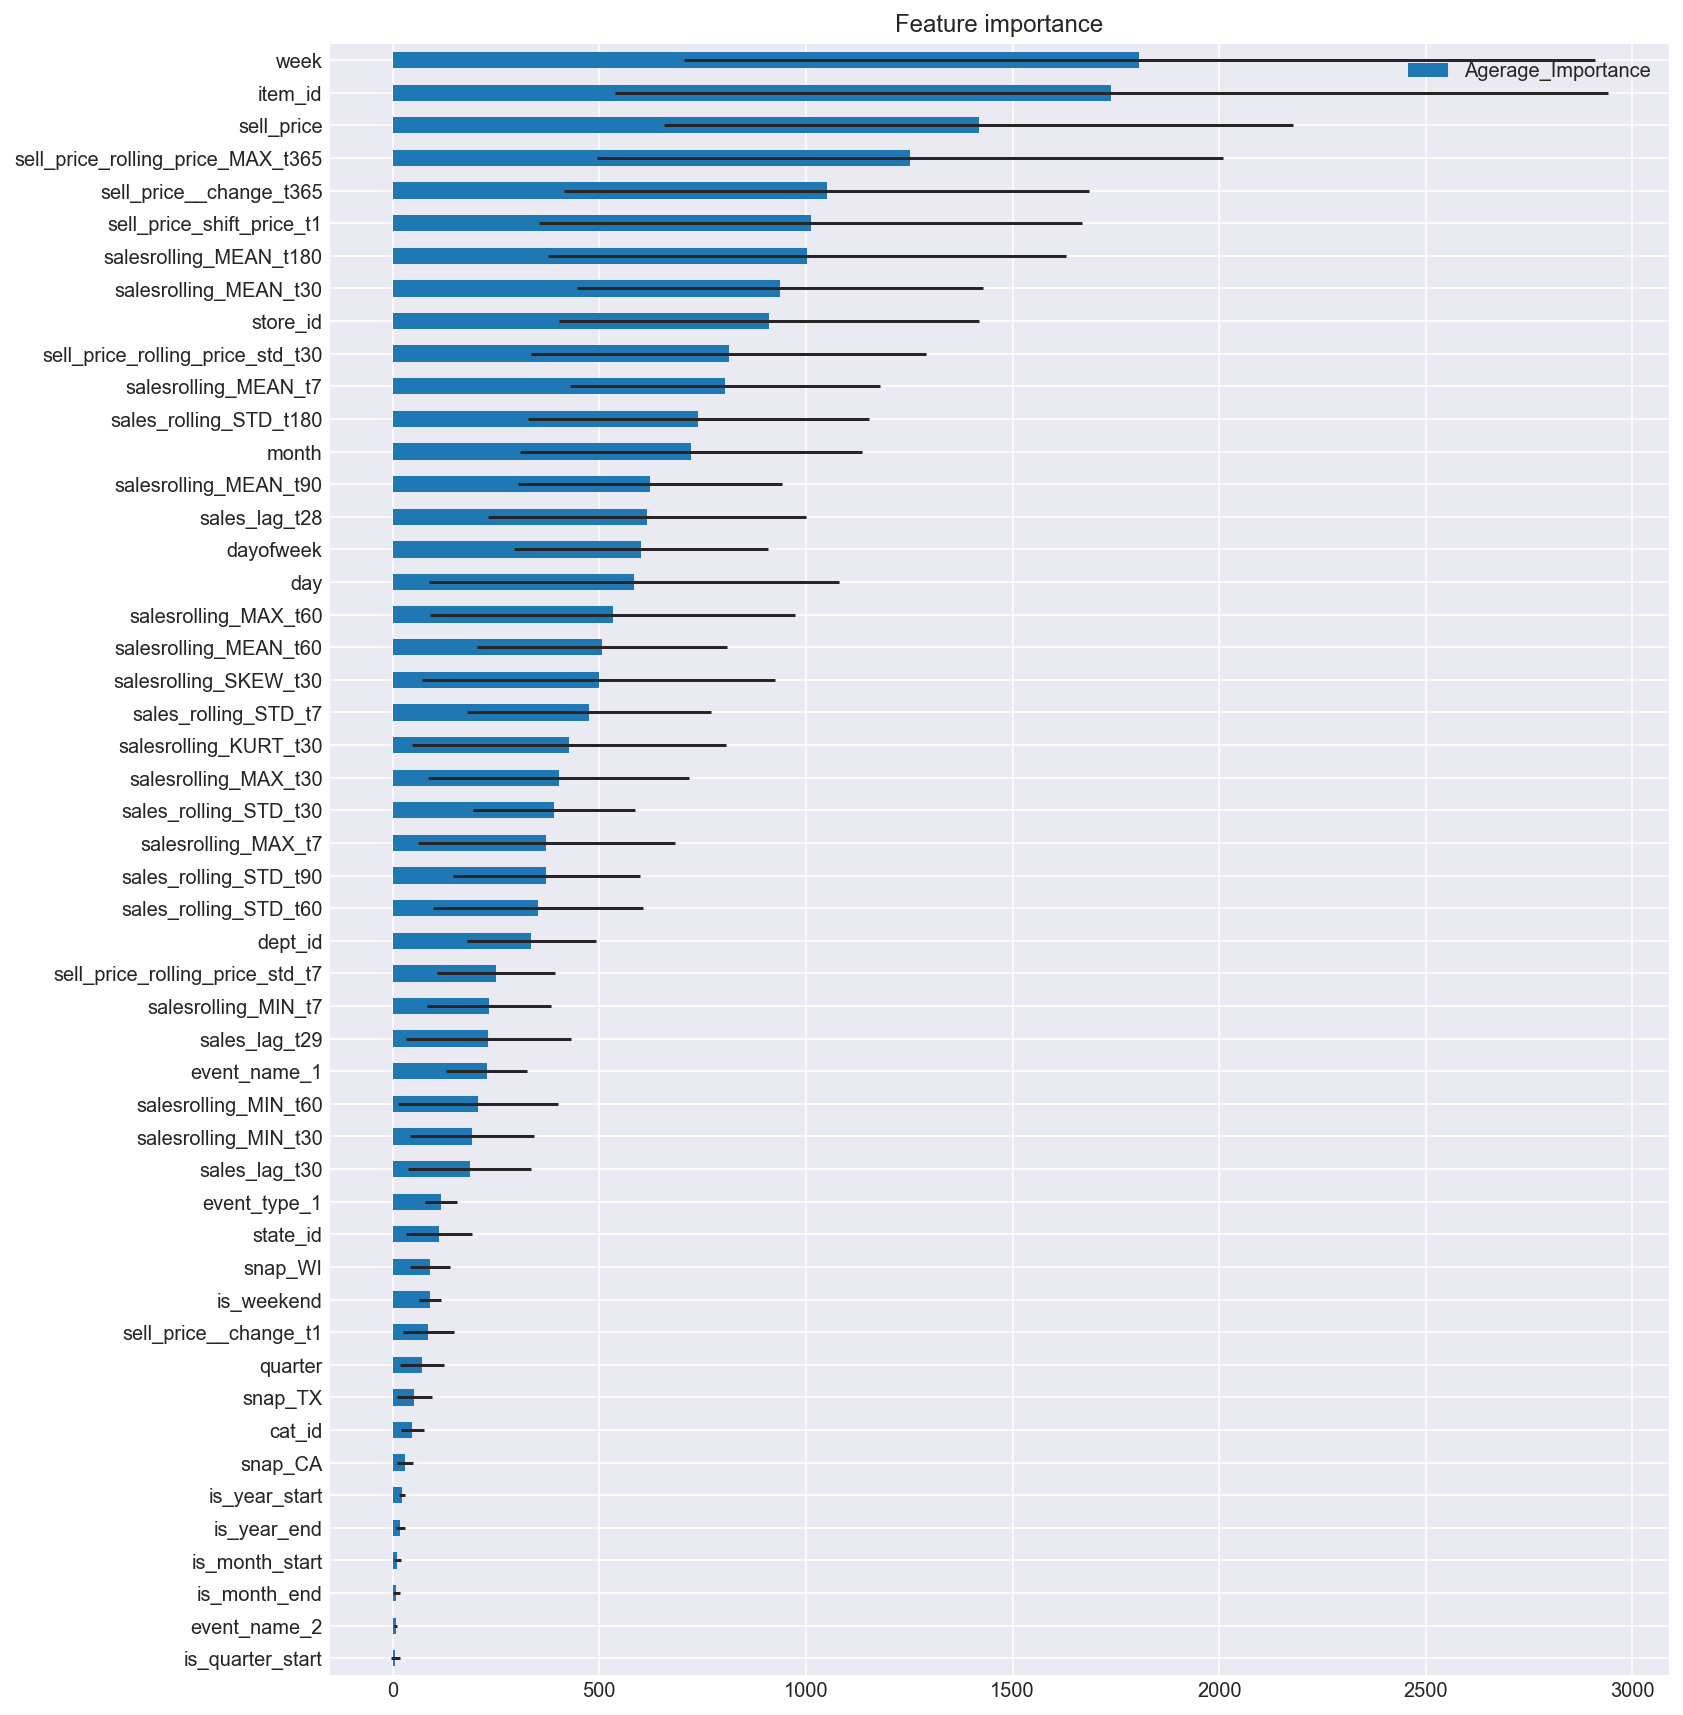

In [141]:
plot_importance(models)

### Vlidation


## Submission